# **Tutorial 5: Calculating Anomalies - Precipitation**

**Week 1, Day 3, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In this tutorial, you will learn how to calculate climate anomalies using satellite climate data records.

By the end of this tutorial you will be able to:

* Calculate a climatology and the corresponding anomaly.
* Calculate the rolling mean of the anomaly data to smooth the time series and extract long-term signals/patterns.


# **Setup**

In [1]:
# !pip install s3fs --quiet

# properly install cartopy in colab to avoid session crash
# !apt-get install libproj-dev proj-data proj-bin --quiet
# !apt-get install libgeos-dev --quiet
# !pip install cython --quiet
# !pip install cartopy --quiet

# !apt-get -qq install python-cartopy python3-cartopy  --quiet
# !pip uninstall -y shapely  --quiet
# !pip install shapely --no-binary shapely  --quiet

In [4]:
# imports 

import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import boto3
import botocore
import pooch
import holoviews
from geoviews import Dataset as gvDataset
import geoviews.feature as gf
from geoviews import Image as gvImage


In [5]:
# @title Video 1: Video 1 Name
#Tech team will add code to format and display the video

In [6]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

# **Section 1: From Climatology to Anomaly**

Building upon your knowledge of climatology from the last tutorial, you will now calculate the anomalies from this climatology. An **anomaly**, in the context of climate studies, represents a departure from standard climatological conditions. For example, if the normal January temperature of the city that you live in is 10 °C and the January temperature of this year is 15 °C. We usually say the temperature anomaly of January this year is 5 °C above normal/ the climatology. The anomaly is an essential tool in detecting changes in climate patterns and is frequently utilized in critical climate reports such as those generated by the [Intergovernmental Panel on Climate Change (IPCC)](https://www.ipcc.ch/).

To calculate an anomaly, we first establish a reference period, usually a 30-year window, to define our climatology. In this process, it is crucial to use high-quality data and aggregate it to the desired spatial resolution and temporal frequency, such as weekly or monthly. The anomaly is then determined by subtracting this long-term average from a given observation, thus creating a useful metric for further climate analysis such as trend analysis.

In this tutorial, we will employ the [CPCP monthly precipitation Climate Data Record (CDR)](https://disc.gsfc.nasa.gov/datasets/GPCPMON_3.2/summary) to compute a monthly anomaly time series. Furthermore, we will learn to calculate the rolling mean of the generated precipitation anomaly time series. This knowledge will be invaluable for our upcoming tutorial on climate variability.

## **Section 1.1: Calculating the Monthly Anomaly**

To calculate anomaly, you first need to calculate the monthly climatology. Since you already learned how to do this during last tutorial, we will fast forward this step. 

In [7]:
# connect to the AWS S3 bucket for the GPCP Monthly Precipitation CDR data
fs = s3fs.S3FileSystem(anon=True)

# get the list of all data files in the AWS S3 bucket
file_pattern = 'noaa-cdr-precip-gpcp-monthly-pds/data/*/gpcp_v02r03_monthly_*.nc'
file_location = fs.glob(file_pattern)

# open connection to all data files
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED)) # initialize aws s3 bucket client
file_ob = [pooch.retrieve('http://s3.amazonaws.com/'+file,known_hash=None ) for file in file_location]

# open all the monthly data files and concatenate them along the time dimension.
# this process will take ~ 1 minute to complete due to the number of data files.
ds = xr.open_mfdataset(file_ob, combine='nested', concat_dim='time')
ds

SHA256 hash of downloaded file: 4bf66b33fcc87414d5c9341a37c7af9dad5214ddc07b48ec97cffa509f241b8e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: d0836fb9f1bcbf8be09b946626c170ddd7764c0b6dc044d90d3a0ca5fbcb928e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 015433aca66f3a6f1a5df835b4d8707d71c8b4cd982d59d7465cebf629a86e1c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: def01006f32b0b8760dde3320e39c68fd961c4df3afa0ccb8e25ecb474d74b7f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: cd1e

<xarray.Dataset>
Dimensions:       (latitude: 72, longitude: 144, time: 530, nv: 2)
Coordinates:
  * latitude      (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude     (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time          (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
Dimensions without coordinates: nv
Data variables:
    lat_bounds    (time, latitude, nv) float32 dask.array<chunksize=(1, 72, 2), meta=np.ndarray>
    lon_bounds    (time, longitude, nv) float32 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    time_bounds   (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip        (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    precip_error  (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     oc.197901.sg
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) �R
`�, Dr. Jian-Jian Wang, U of Maryland,...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    ...                         ...
    metadata_link:              gov.noaa.ncdc:C00979
    product_version:            v23rB1
    platform:                   NOAA POES (Polar Orbiting Environmental Satel...
    sensor:                     AVHRR>Advanced Very High Resolution Radiometer
    spatial_resolution:         2.5 degree
    comment:                    Processing computer: eagle2.umd.edu

In [8]:
# calculate climatology using `.sel()` and `.groupby()` directly.
precip_clim = ds.precip.sel(time=slice('1981-01-01', '2010-12-01')).groupby('time.month').mean(dim='time')
precip_clim

<xarray.DataArray 'precip' (month: 12, latitude: 72, longitude: 144)>
dask.array<transpose, shape=(12, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

Now we have the monthly precipitation climatology. How can we calculate the monthly anomaly?

As we learned before - let's use `.groupby()` from `xarray`. We can split the entire time period based on the month of the year and then subtract the climatology of that specific month from the monthly value and recombine the value together.

In [10]:
# use `.groupby()` to calculate the monthly anomaly
precip_anom = ds.precip.groupby('time.month') - precip_clim
precip_anom

/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 45 times more chunks
  return self.array[key]


<xarray.DataArray 'precip' (time: 530, latitude: 72, longitude: 144)>
dask.array<sub, shape=(530, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 4 5 6 7 8 9 10 11 12 1 2

You may have noticed that there is an additional coordinate in the anomaly dataset. The additional coordinate is `month` which is a direct outcome because of the `.groupby()` action we just performed.

If you want to save the data for future use, you can write the data out to a netCDF file using `.to_netcdf()`. It will automatically carry all the coordinates, dimensions, and relevant information into the netCDF file.

In [11]:
# an example of how to export the GPCP monthly anomaly data comparing to the climatology period of 1981-2010.
# precip_anom.to_netcdf('t5_gpcp-monthly-anomaly_1981-2010.nc')

## **Section 1.2: Examining the Anomaly**

First, let's take a look at the geospatial pattern of the monthly anomaly of a selected month – January of 1979.

/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


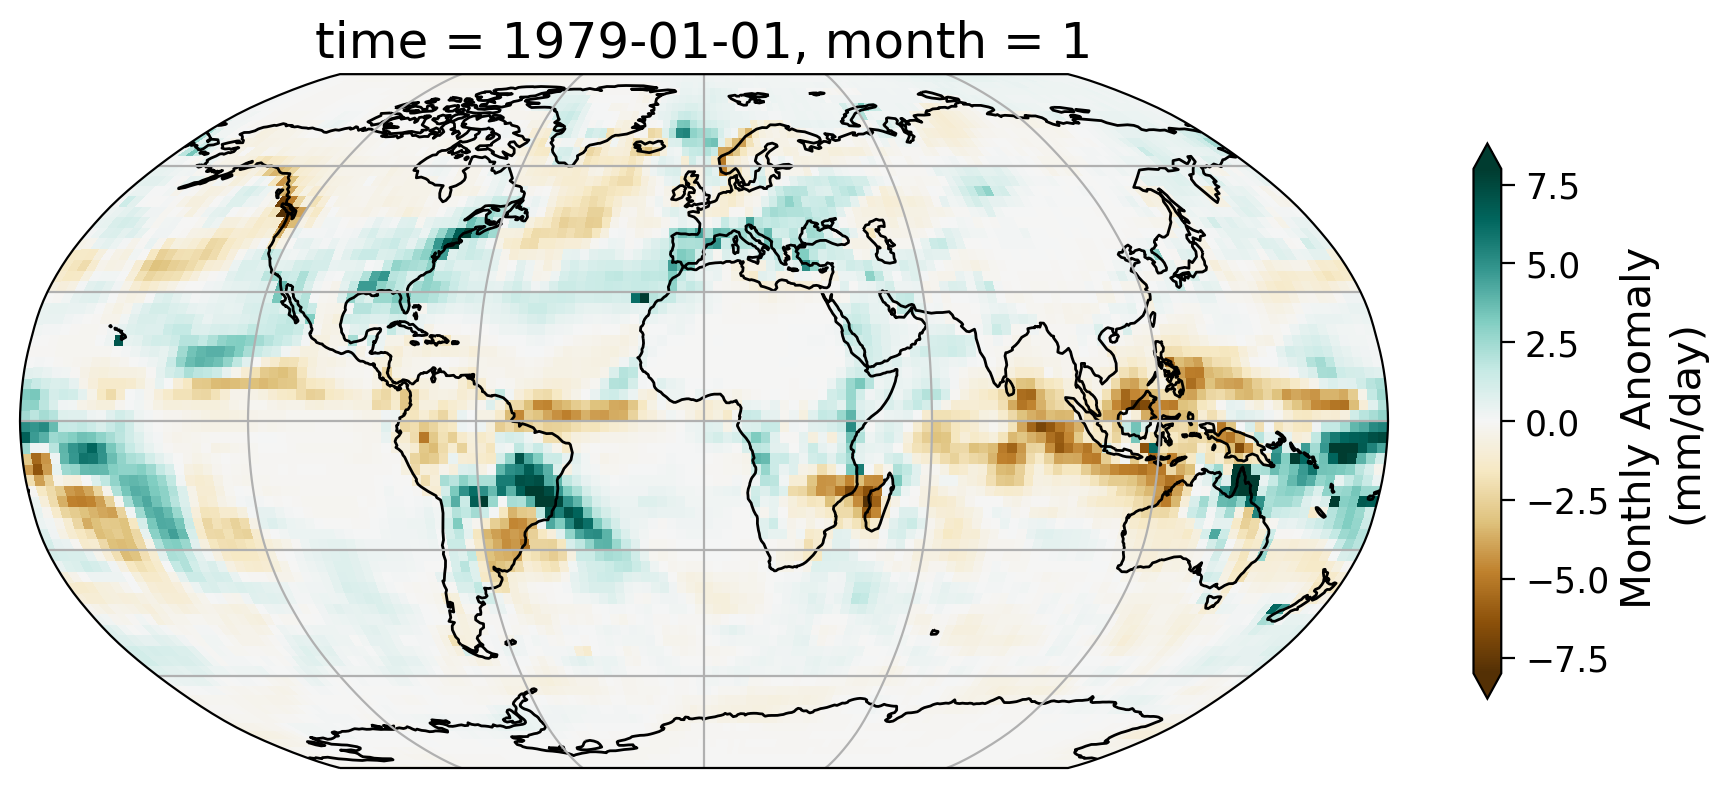

In [12]:
# initate plot
fig = plt.figure(figsize=(9,6))

# set map projection
ax = plt.axes(projection=ccrs.Robinson())

# add coastal lines to indicate land/ocean
ax.coastlines()

# add grid lines for latitude and longitude
ax.gridlines()

# add the precipitation data for
precip_anom.sel(time='1979-01-01').plot(ax=ax, transform=ccrs.PlateCarree(),
                                        vmin=-8, vmax=8, cmap='BrBG',
                                        cbar_kwargs=dict(shrink=0.5, label='Monthly Anomaly \n(mm/day)'))

From the map of this monthly anomaly, we can see the spatial pattern of how precipitation for the January of 1979 has departed from the 30-year normal. Part of the Amazon saw notable increase of precipitation during this month as well as the northeast coast of the United States. 

### Interactive Demo 1.2

In the interactive demo below (make sure to run the code) you will be able to scroll through the anomaly for a few months in 1979 to see how it changes from month to month during this year.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
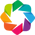

/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181:

:HoloMap   [time]
   :Overlay
      .Image.I     :Image   [longitude,latitude]   (precip)
      .Coastline.I :Feature   [Longitude,Latitude]

In [13]:
holoviews.extension('bokeh')
dataset_plot = gvDataset(precip_anom.isel(time=slice(0,10))) # only the first 10, as it is a time consuming task 
images = dataset_plot.to(gvImage, ['longitude', 'latitude'], ['precip'], 'time')
images.opts(cmap='BrBG', colorbar=True, width=600, height=400,projection=ccrs.Robinson(),
            clim=(-8,8),clabel ='Monthly Anomaly \n(mm/day)') * gf.coastline


To visualize the changes in the precipitation anomaly over many months, we can also take a look at the time series of a selected grid. We will use the same point (0°N, 0°E) that we used as an example in the last tutorial.

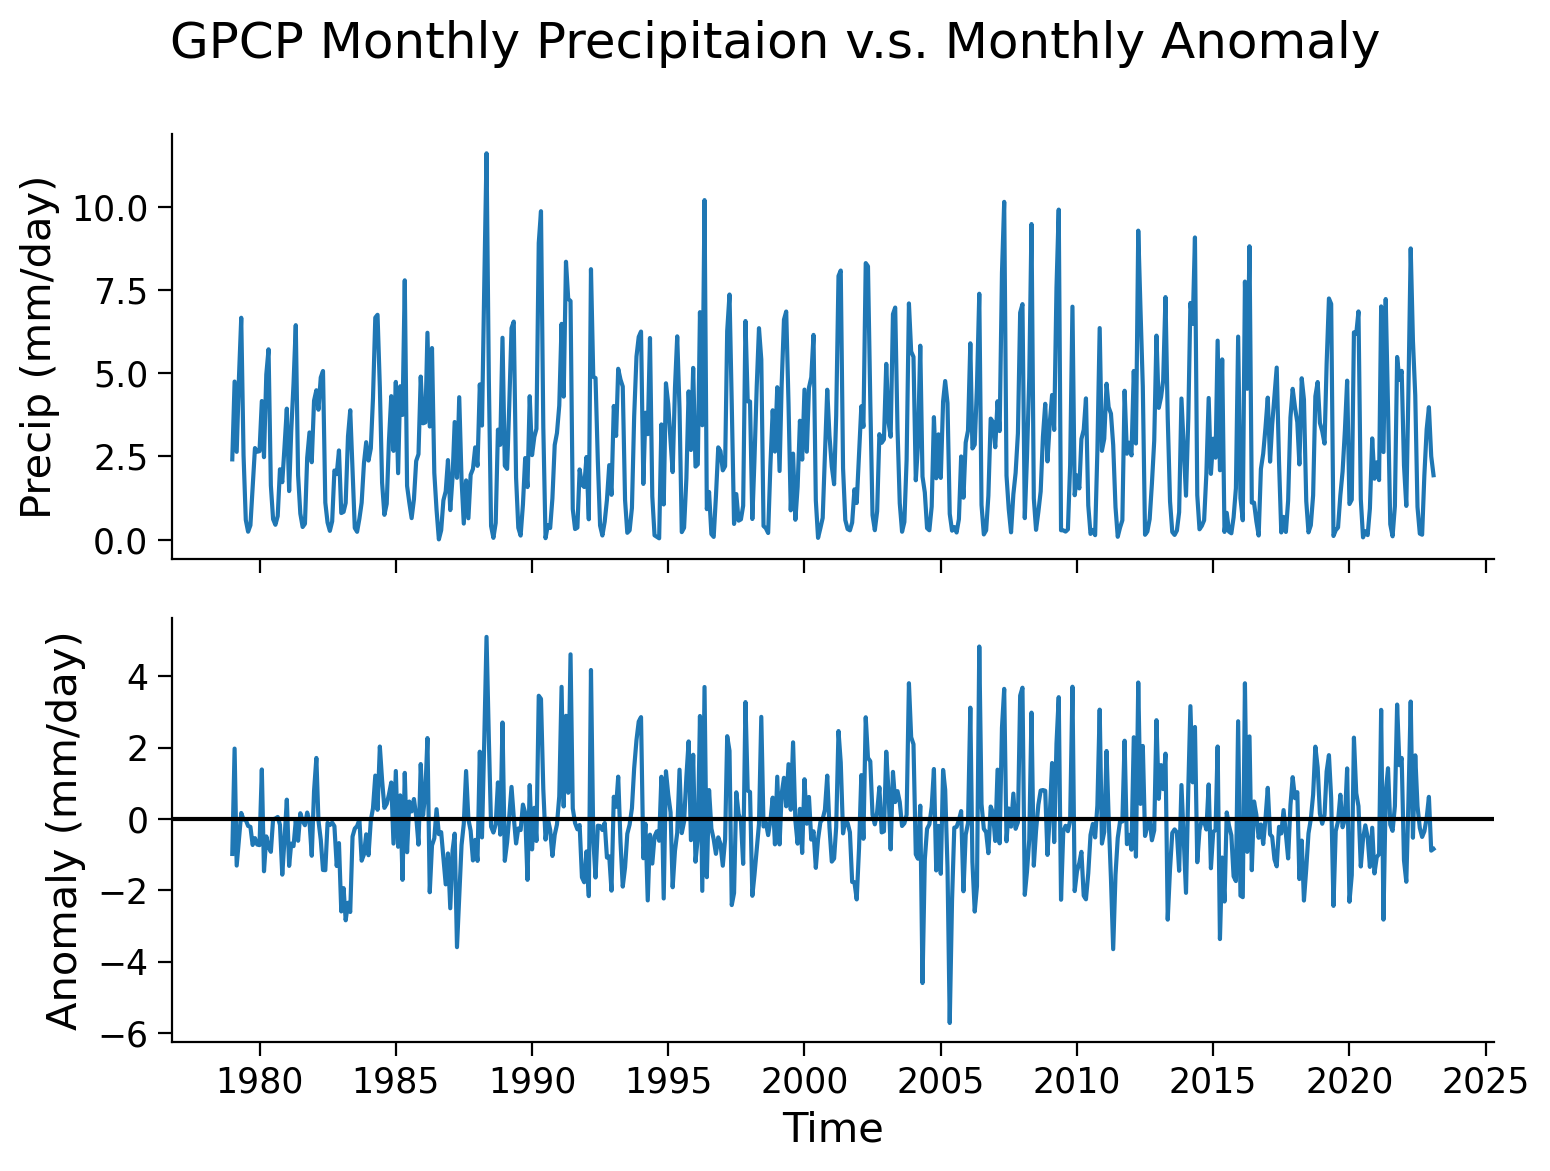

In [15]:
# set up two subplots that share the x-axis to compare monthly precipitation and monthly anomaly
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('GPCP Monthly Precipitaion v.s. Monthly Anomaly')
axs[0].plot(ds.time, ds.precip.sel(latitude=0, longitude=0, method='nearest'))
axs[0].set_ylabel('Precip (mm/day)')
axs[1].plot(precip_anom.time, precip_anom.sel(latitude=0, longitude=0, method='nearest'))
axs[1].set_ylabel('Anomaly (mm/day)')
axs[1].set_xlabel('Time')

# add horizontal line of y=0 for the anomaly subplot
axs[1].axhline(y=0, color='k', linestyle='-')

Note that, unlike the upper panel showing precipitation values, the lower panel displaying the monthly anomaly not exhibit distinct seasonal cycles. This discrepancy highlights one of the advantages of utilizing anomaly data for climate analysis. By removing the repetitive patterns induced by seasonality or other stable factors, we can effectively isolate the specific signals in the data that are of interest, such as climate variability or climate trends. This approach allows for a clearer focus on the desired climate-related patterns without the interference of predictable seasonal variations.

# **Section 2: Anomaly Analysis**

In this section, we are going to explore a few different analyses on the anomaly data: 

- Calculating rolling mean
- Calculating global mean

You have already practiced using these tools during the last two days or material, here we will focus on applying them to a much longer satellite data record than you have encountered previously.

## **Section 2.1: Rolling Mean**

The monthly anomaly time series often contains noisy data that may obscure the patterns associated with large-scale climate variability. To mitigate this noise and enhance the visibility of underlying patterns, we can apply a rolling mean technique using the `.rolling()` function. This approach involves smoothing the monthly time series to facilitate the identification of climate variability.

In [17]:
# Calculate 12-month rolling mean for the selected location
grid_month = precip_anom.sel(latitude=0, longitude=0, method='nearest')
grid_rolling = grid_month.rolling(time=12, center=True).mean()

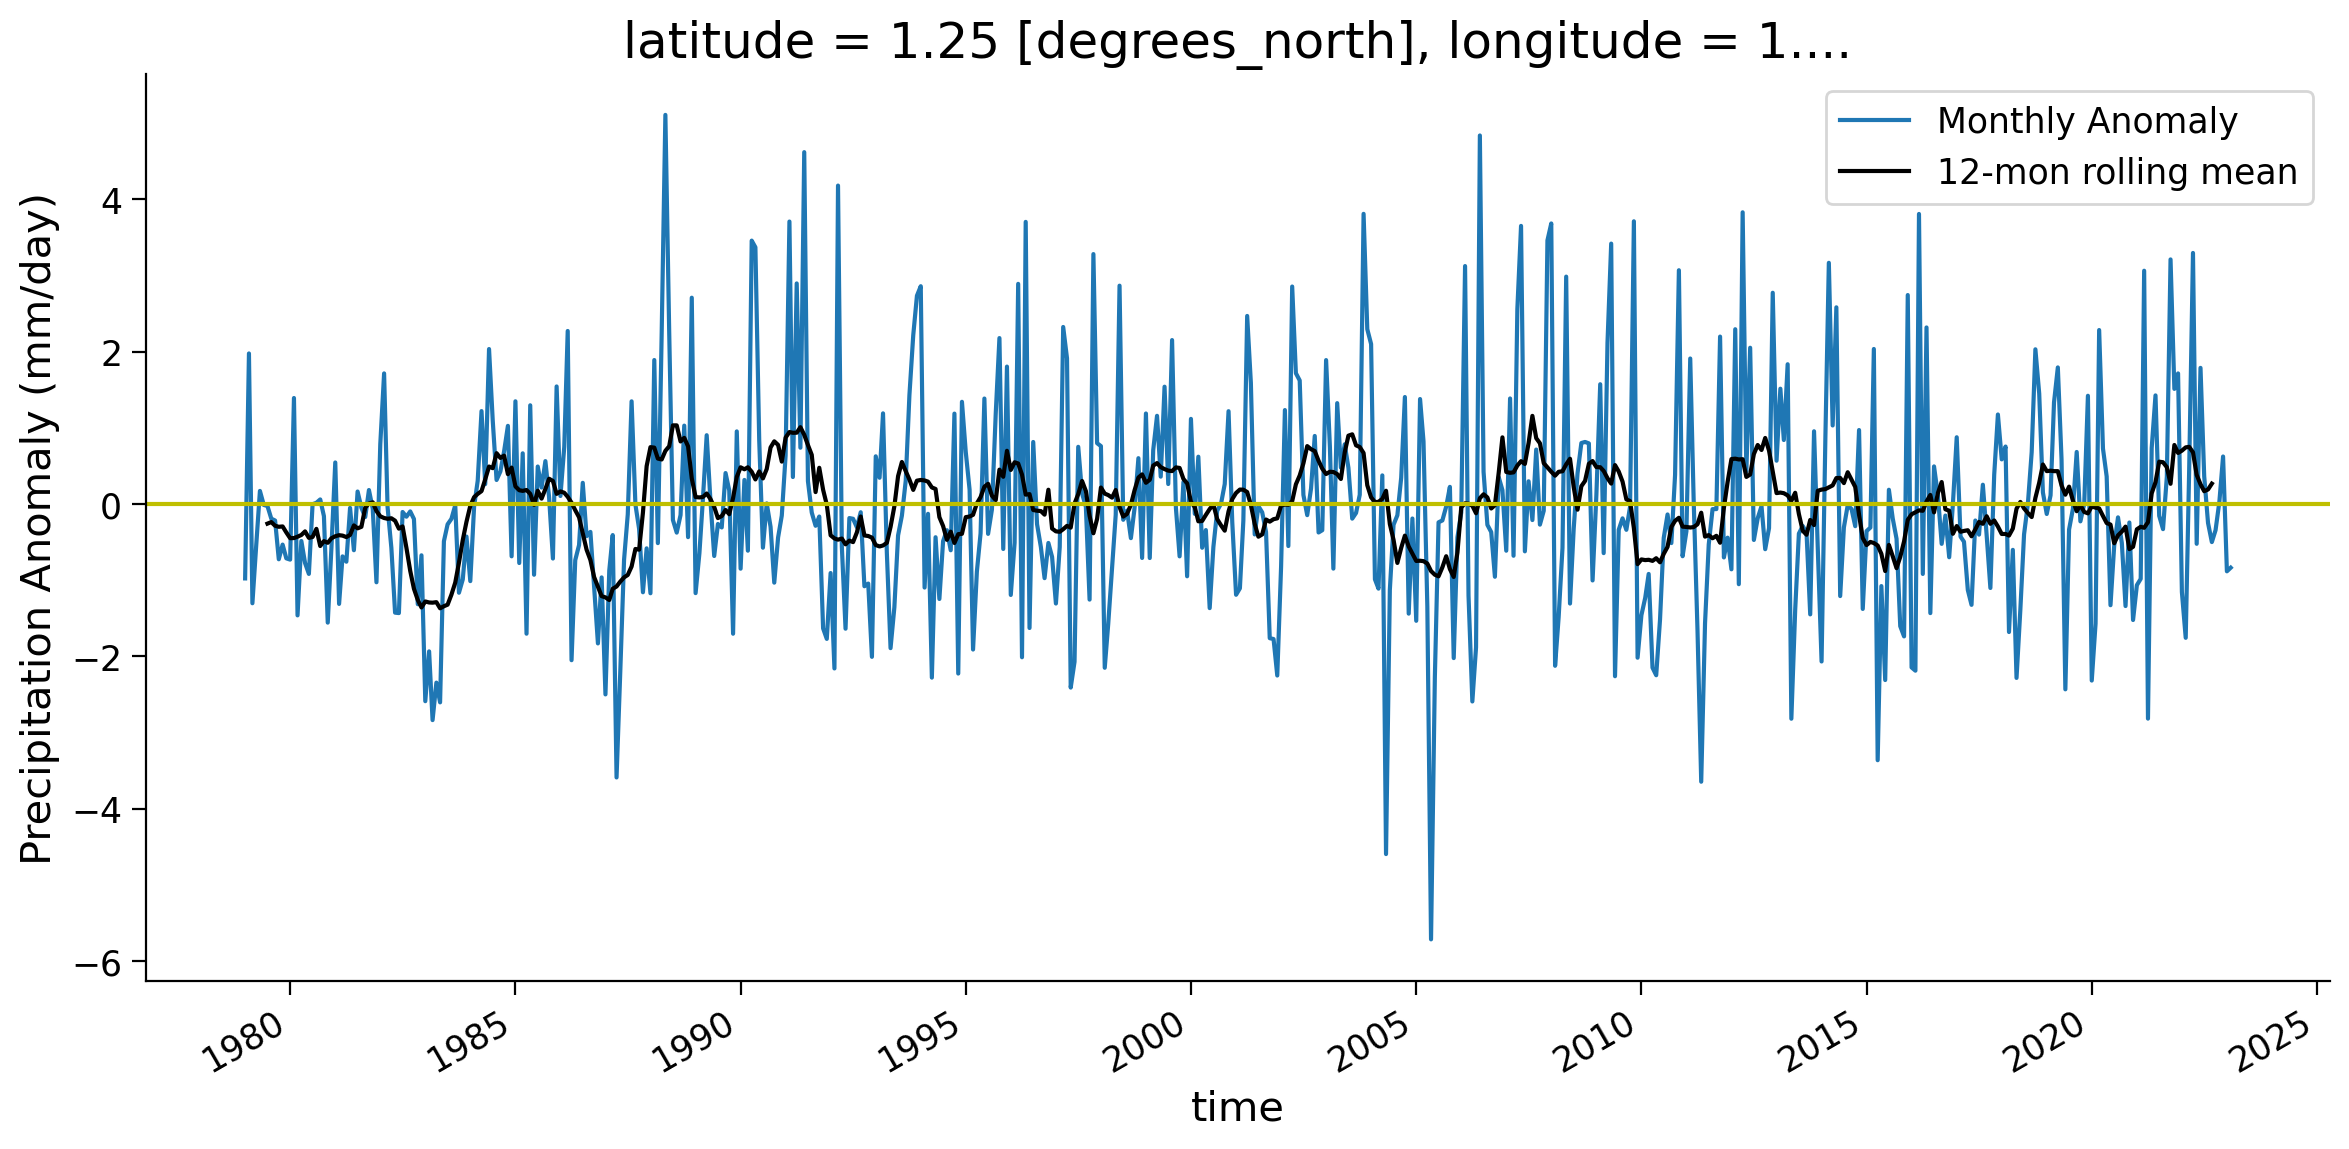

In [42]:
# Create the time series plot of monthly anomaly
fig = plt.figure(figsize=(12,6))
grid_month.plot(label='Monthly Anomaly')
grid_rolling.plot(color='k', label='12-mon rolling mean')
plt.axhline(y=0, color='y', linestyle='-')
plt.ylabel('Precipitation Anomaly (mm/day)')
plt.legend()

As you can see, the 12-month rolling mean removes the high-frequency variations of monthly precipitation anomaly data, allowing the slower-changing patterns of precipitation to become more apparent.

### Coding Exercises 2.1

1. Can you calculate the 24-month rolling mean for the same grid and compare the three different time series (monthly anomaly, 12-month rolling mean, 24-month rolling mean)?

In [ ]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Compare monthly anomaly with 12-month and 24-month rolling mean.")
#################################################

# calculate 24-month rolling mean
grid_rolling_24m = ...

# plot all three time series together with different colors
...

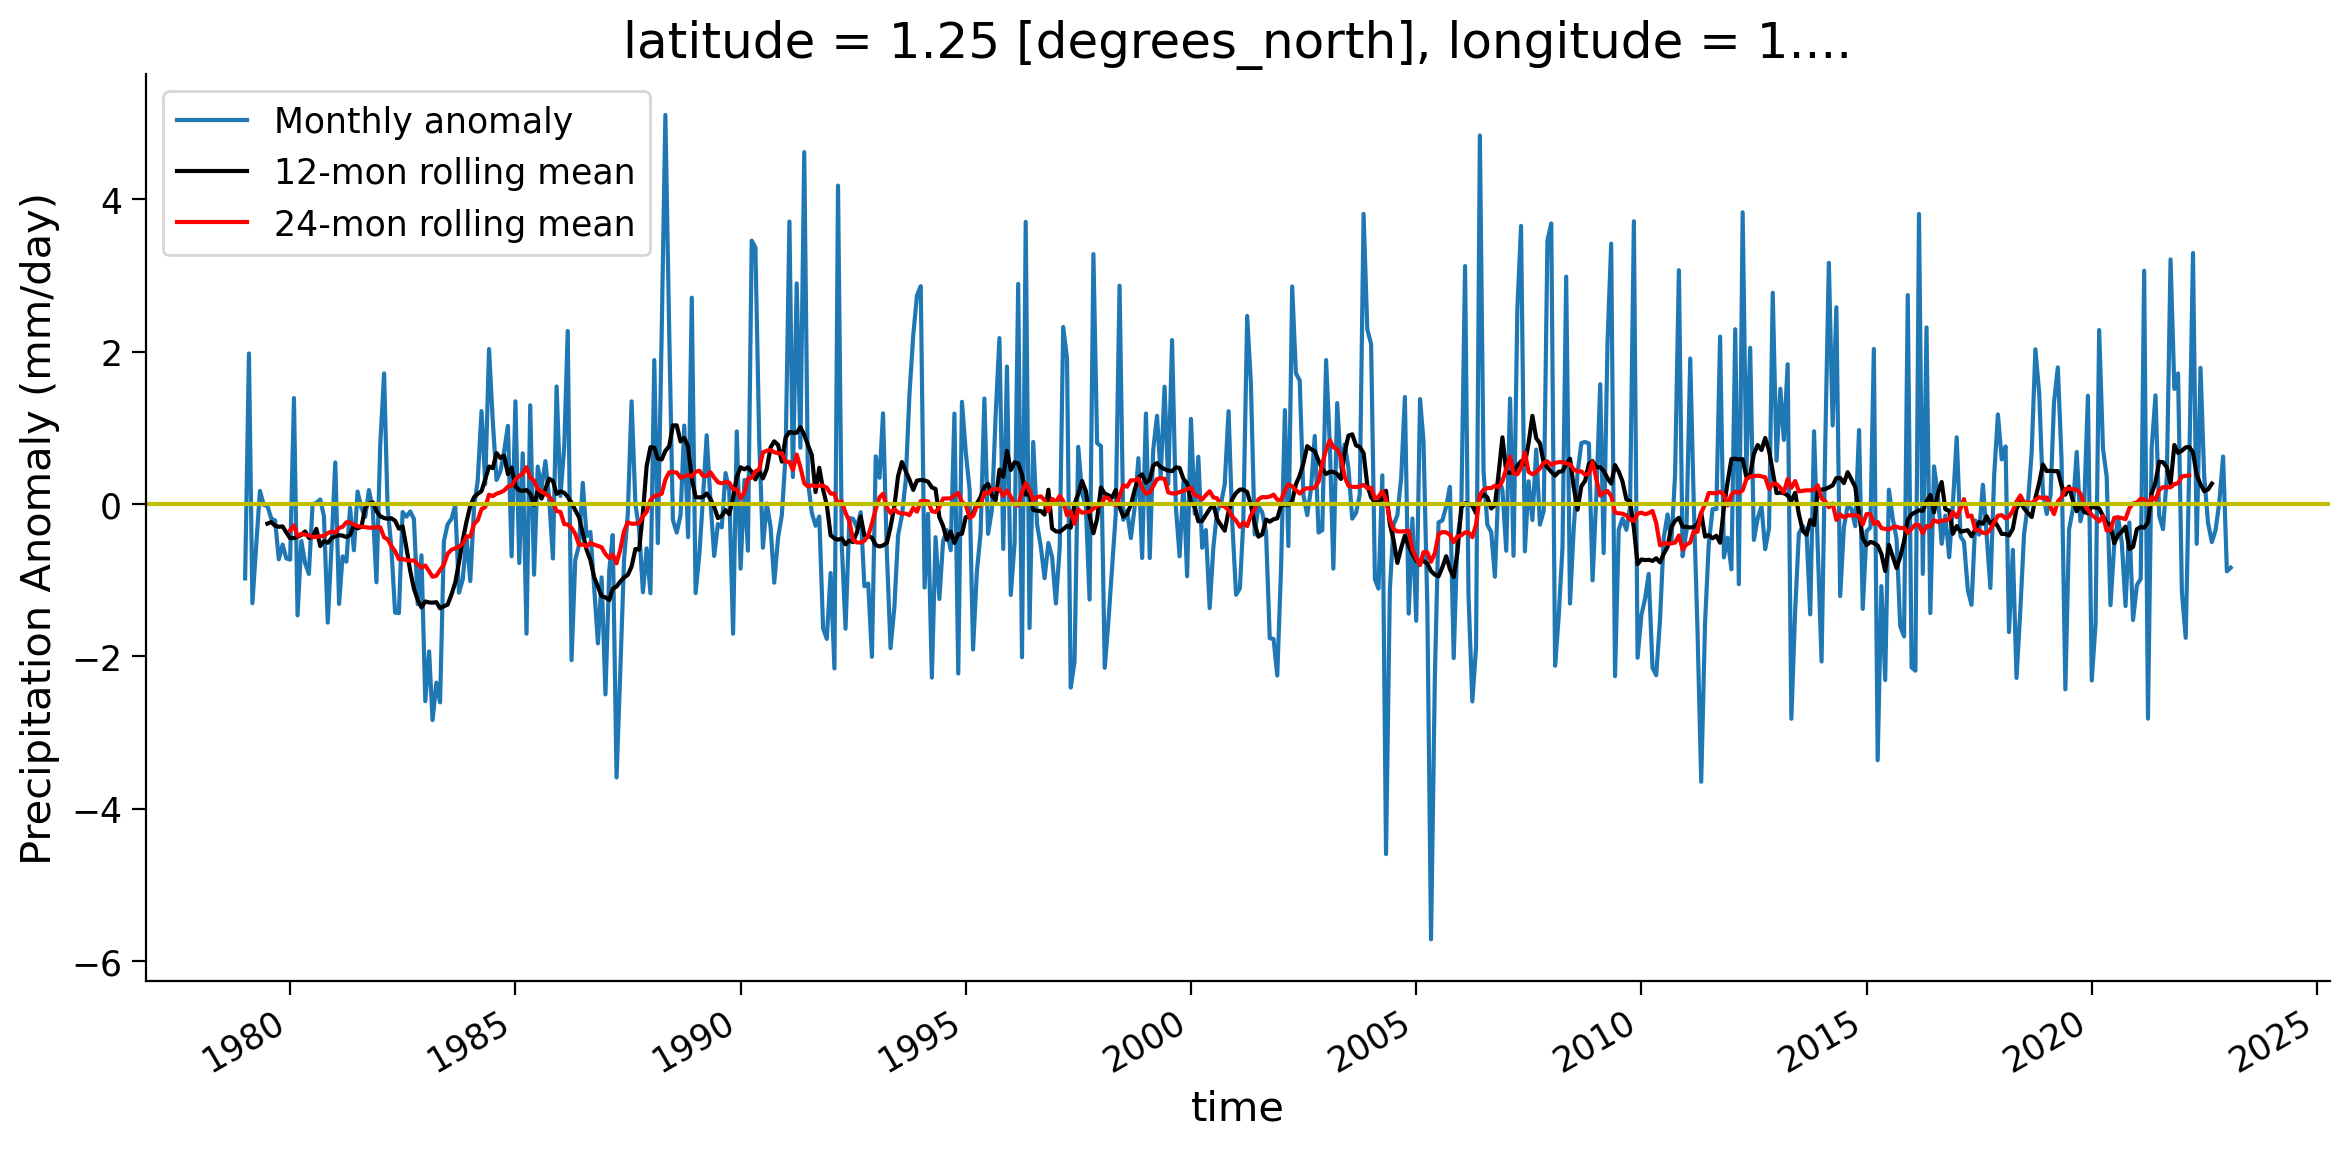

In [43]:
# to remove solution

# calculate 24-month rolling mean
grid_rolling_24m = grid_month.rolling(time=24, center=True).mean()

# plot all three time series together with different colors
fig = plt.figure(figsize=(12,6))
grid_month.plot(label='Monthly anomaly')
grid_rolling.plot(color='k', label='12-mon rolling mean')
grid_rolling_24m.plot(color='r', label='24-mon rolling mean')
plt.axhline(y=0, color='y', linestyle='-')
plt.ylabel('Precipitation Anomaly (mm/day)')
plt.legend()

### Questions 2.1

1. What are the major differences you notice between the 12 and 24 month rolling averages?
2. What criteria would you use to determine the window size to use in a rolling average of a satellite derived climate variable such as precipitation anomalies?

In [26]:
# to_remove explanation

"""

1. The 24 monthis smoother still, and in this case some of the 'bumps' rather than 'spiked' are removed. 
2. 

"""

"\n\n1. The 24 monthis smoother still, and in this case some of the 'bumps' rather than 'spiked' are removed. \n2. \n\n"

## **Section 2.2: Global Mean**

When examining global-scale changes, it is common to aggregate global mean values from all grid cells. However, it is important to note that despite each grid having the same resolution of `2.5°×2.5°`, they represent different areas on the Earth's surface. Specifically, the same grid covers larger spatial areas in the tropics compared to the polar regions as discussed in the climate system overview day.

To address this issue, it is necessary to weight the values based on their respective surface areas. Unlink the model data you used previously, where you had the grid cell area available as a variable, for our gridded observations we will use weights based on the cosine of the latitude as this function takes into account the decreasing area towards the poles.

In [28]:
# calculate the weights using the latitude coordinates
weights = np.cos(np.deg2rad(precip_anom.latitude))
weights.name = "weights"
weights

<xarray.DataArray 'weights' (latitude: 72)>
array([0.02181496, 0.06540319, 0.10886693, 0.15212344, 0.19509035,
       0.23768592, 0.27982906, 0.32143947, 0.36243805, 0.4027467 ,
       0.4422887 , 0.48098874, 0.5187732 , 0.55557024, 0.59130967,
       0.62592345, 0.6593458 , 0.691513  , 0.72236395, 0.7518398 ,
       0.77988446, 0.8064446 , 0.8314696 , 0.85491186, 0.87672675,
       0.89687276, 0.91531146, 0.93200785, 0.9469301 , 0.96004987,
       0.9713421 , 0.98078525, 0.98836154, 0.99405634, 0.99785894,
       0.999762  , 0.999762  , 0.99785894, 0.99405634, 0.98836154,
       0.98078525, 0.9713421 , 0.96004987, 0.9469301 , 0.93200785,
       0.91531146, 0.89687276, 0.87672675, 0.85491186, 0.8314696 ,
       0.8064446 , 0.77988446, 0.7518398 , 0.72236395, 0.691513  ,
       0.6593458 , 0.62592345, 0.59130967, 0.55557024, 0.5187732 ,
       0.48098874, 0.4422887 , 0.4027467 , 0.36243805, 0.32143947,
       0.27982906, 0.23768592, 0.19509035, 0.15212344, 0.10886693,
       0.06540319, 0.02181496], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    valid_range:    [-90.  90.]
    axis:           Y
    bounds:         lat_bounds

In [29]:
# calculate weighted global monthly mean
anom_weighted = precip_anom.weighted(weights)
global_weighted_mean = anom_weighted.mean(('latitude', 'longitude'))
global_weighted_mean

<xarray.DataArray 'precip' (time: 530)>
dask.array<truediv, shape=(530,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 4 5 6 7 8 9 10 11 12 1 2

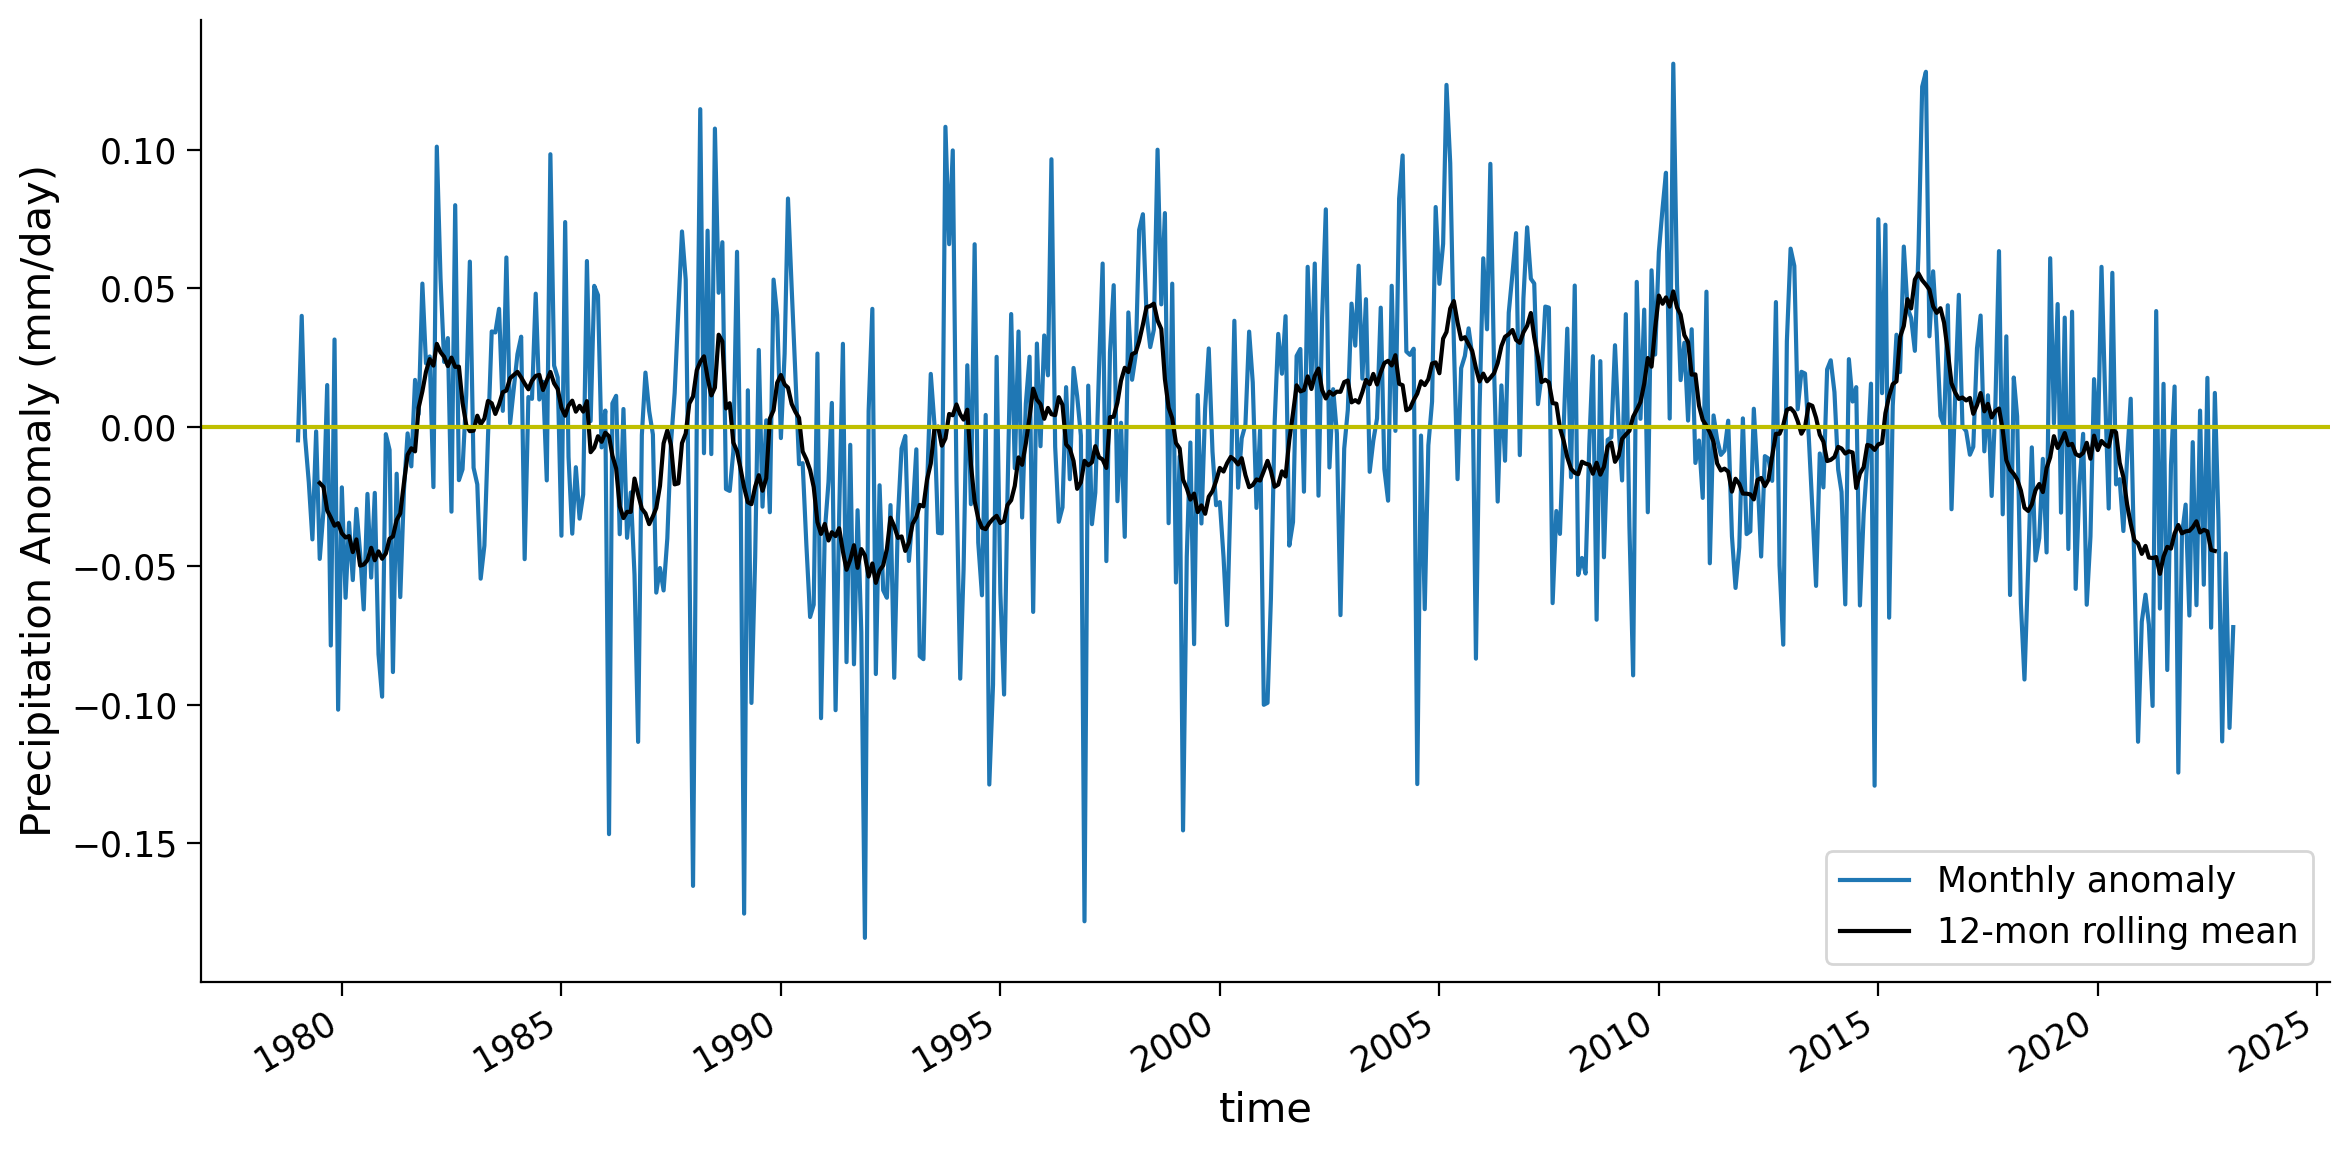

In [44]:
# create the time series plot of global weighted monthly anomaly
fig = plt.figure(figsize=(12,6))
global_weighted_mean.plot(label='Monthly anomaly')
global_weighted_mean.rolling(time=12, center=True).mean(('latitude', 'longitude')).plot(color='k', label='12-mon rolling mean')
plt.axhline(y=0, color='y', linestyle='-')
plt.ylabel('Precipitation Anomaly (mm/day)')
plt.legend()

### Coding Exercises 2.2

1. Plot the 12-month rolling average of the difference between the global weighted and unweighted mean time series.


In [47]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Compare global weighted and unweighted mean time series.")
#################################################

# calculate unweighted global mean
global_unweighted_mean = ...

# calculate different between weighted and unweighted global mean
global_diff = global_weighted_mean - global_unweighted_mean

# plot the time series of the difference
...

NotImplementedError: Student exercise: Compare global weighted and unweighted mean time series.

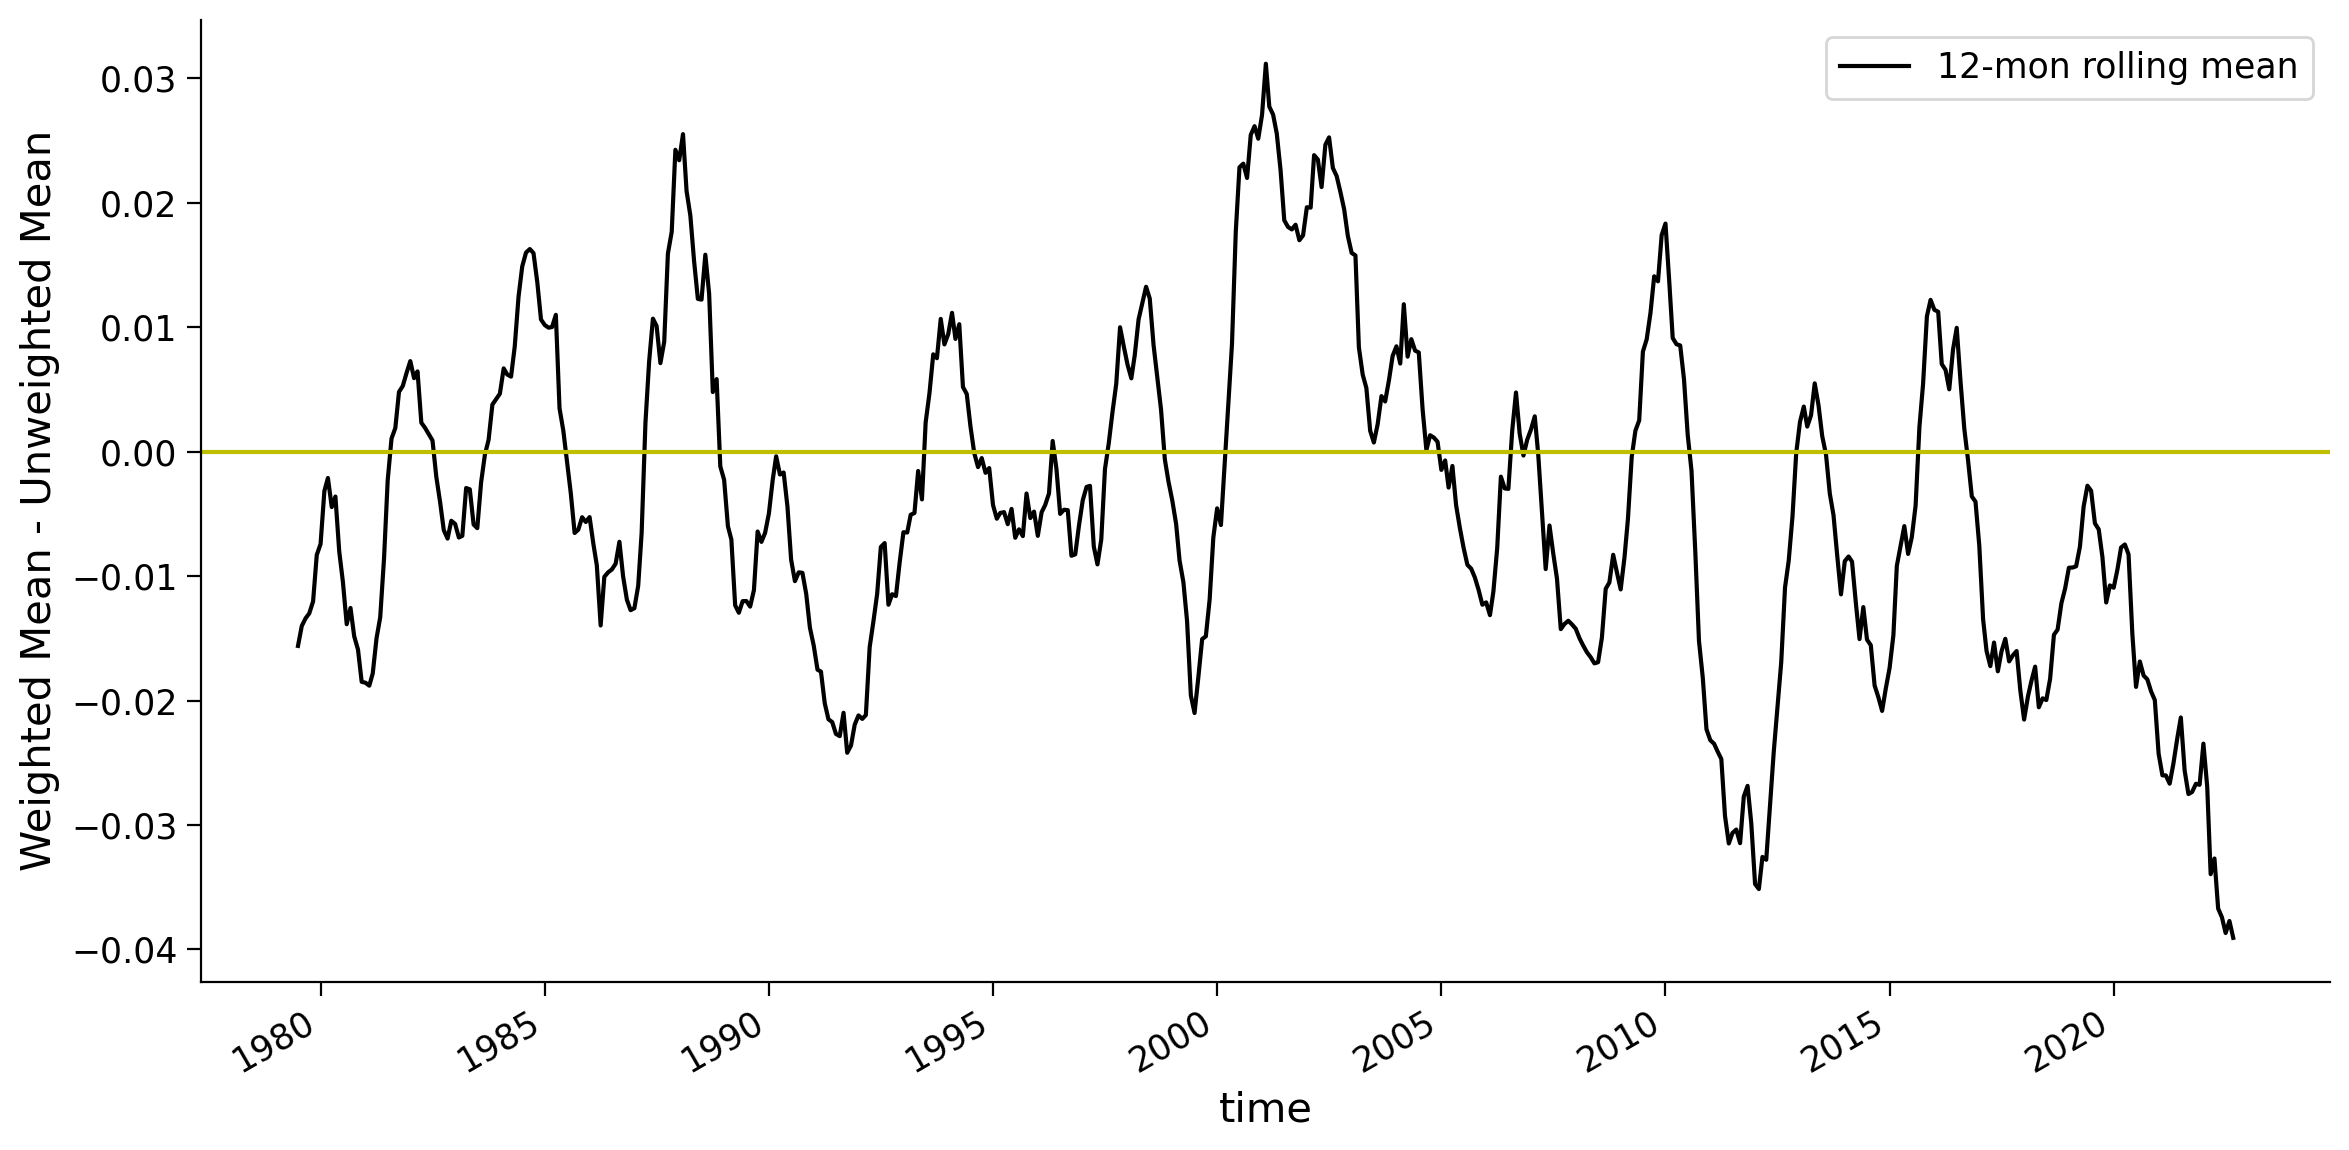

In [46]:
# to remove solution

# calculate unweighted global mean
global_unweighted_mean = precip_anom.mean(('latitude', 'longitude'))

# calculate different between weighted and unweighted global mean
global_diff = global_weighted_mean - global_unweighted_mean

# plot the time series of the difference
fig = plt.figure(figsize=(12,6))
global_diff.rolling(time=12, center=True).mean(('latitude', 'longitude')).plot(color='k', label='12-mon rolling mean')
plt.axhline(y=0, color='y', linestyle='-')
plt.ylabel('Weighted Mean - Unweighted Mean')
plt.legend()

### Questions 2.2

1. Give one example of why the weighted mean might be *higher* than the unweighted mean, as in the 2000-2004 period.
2. Give one example of why the weighted mean might be *lower* than the unweighted mean, as seen from 2017 onwards.

In [55]:
# to_remove explanation

"""

1. In the unweighted mean all the data contribute equally to the mean, but in the weighted mean the low-latitudes contribute most. One reason that the unweighted mean could be higher than the weighted mean would be if a region in the high latitudes had anomously high or low precipitation. Because of the small area towards the poles, the effect of this anomaly on the global mean would be muted by weighting, and the unweighted mean would thus be higher.

2. Following the explanation in Answer 1, if the unweighted mean is lower than the weighted mean, then a low latitude region could have anomolously high or low precipitation. Because of the larger area in the equatorial regions, this anomaly would count more towards the weighted mean, and thus it would be less than 

"""

'\n\n1. In the unweighted mean all the data contribute equally to the mean, but in the weighted mean the low-latitudes contribute most. One reason that the unweighted mean could be higher than the weighted mean would be if a region in the high latitudes had anomously high or low precipitation. Because of the small area towards the poles, the effect of this anomaly on the global mean would be muted by weighting, and the unweighted mean would thus be higher.\n\n2. Following the explanation in Answer 1, if the unweighted mean is lower than the weighted mean, then a low latitude region could have anomolously high or low precipitation. Because of the larger area in the equatorial regions, this anomaly would count more towards the weighted mean, and thus it would be less than \n\n'

# **Summary**

In this tutorial, you learned how to calculate a climate anomaly using satellite derived precipitation data. 

* The anomaly allows us to look at the signals that may be covered by the seasonal cycle pattern (e.g., temperature/precipitation seasonal cycle).
* The anomaly data can be further smoothed using rolling mean to reveal longer-term signals at annual or decade time scale.

We will use the anomaly concept to study climate variability in the next tutorial.


# Resources

Data from this tutorial can be accessed [here](https://noaa-cdr-precip-gpcp-monthly-pds.s3.amazonaws.com/index.html#data/)